### ЛАБОРАТОРНАЯ РАБОТА №3. ВСПЛЫТИЕ ПОДВОДНОЙ ЛОДКИ
**Цель работы**: изучить методы численного дифференцирования для
решения системы обыкновенных дифференциальных уравнений и применить их
на практике для решения практической задачи (определения траектории и точки
всплытия подводной лодки).



In [267]:
from typing import Callable, List, Tuple
import numpy as np
import matplotlib.pyplot as plt

# Дано
eta = 0.001
rho0 = 1025
g = 9.8
alpha = 0.01
rho1 = 950

# Задать самому
V = 900 # объём
S = 180 # площадь
l = V/S # длина
H = 50 # глубина
v = 10 # скорость

k = S / l

# Метод Рунге–Кутта 4 порядка
def rk4(f: Callable[[float, np.ndarray], np.ndarray], a: float, b: float, y0: np.ndarray, h: int) -> Tuple[np.ndarray, np.ndarray]:
    m = len(y0)
    # h = (b - a) / n
    x = np.arange(a, b, h)
    n = len(x)
    y = np.zeros((n, m))
    
    k1 = h * f(a, y0)
    k2 = h * f(a + h/2, y0 + k1/2)
    k3 = h * f(a + h/2, y0 + k2/2)
    k4 = h * f(a + h, y0 + k3)
    
    y[0, :] = y0 + k1/6 + k2/3 + k3/3 + k4/6
    
    for i in range(n - 1):
        k1 = h * f(x[i], y[i, :])
        k2 = h * f(x[i] + h/2, y[i, :] + k1/2)
        k3 = h * f(x[i] + h/2, y[i, :] + k2/2)
        k4 = h * f(x[i] + h, y[i, :] + k3)
        y[i + 1, :] = y[i, :] + k1/6 + k2/3 + k3/3 + k4/6
    
    x = np.concatenate(([a], x))
    y = np.concatenate((y0.reshape(1, m), y))
    
    return x, y


# Функция для системы уравнений
def submarine_sys(t: float, y: np.ndarray):
    dy = y[1]
    dz = -(eta*k / (V*rho1)) * (1 + alpha*y[0]/H)*dy + g*(rho0/rho1-1)
    return np.array([dy, dz])

# Начальные условия
y0 = np.array([0, 0])
a = 0
b = 15
# n= 10000
h = 0.01
# Решение системы дифференциальных уравнений
solution: Tuple[np.ndarray, np.ndarray] = rk4(submarine_sys, a, b, y0, h)

# Убираем значения, где y0 > 0
# solution_x = solution[0]
# solution_y = solution[1]
solution_x = solution[0][solution[1][:, 0] <= H]
solution_y = solution[1][solution[1][:, 0] <= H]

half =  rk4(submarine_sys, a, b, y0, h / 2)
# half_x = half[0]
# half_y = half[1]
half_x = half[0][half[1][:, 0] <= H]
half_y = half[1][half[1][:, 0] <= H]

runge_errs = [solution_y[:, 0][i] - half_y[:, 0][i * 2] for i in range(len(solution_y[:,0]))]
runge_err = max(runge_errs) / 15
print(f"Погрешность по правилу Рунге: {runge_err}")


Погрешность по правилу Рунге: 9.237055564881303e-15


Коэффициенты квадратичного полинома методом наименьших квадратов: 
a = 0.38684200458192725
b = 0.007737369463302177
c = 3.79859010453775e-05
Среднеквадратичное отклонение: 1.3020698176449067e-12
[inf, 0.018051537464669386, 0.004478868225573529, 0.0019755474649423674, 0.001102806216820733, 0.0007004155565651596, 0.00048267762992694507, 0.00035189624319938693, 0.00026734299672155447, 0.00020959878340164634, 0.00016845564070732687, 0.00013813337845959797, 0.00011516128320936768, 9.735397156332395e-05, 8.328024075302249e-05, 7.197129742335857e-05, 6.275259589928127e-05, 5.514288662670125e-05, 4.879145102772249e-05, 4.343787091921528e-05, 3.888554299814141e-05, 3.498382467860787e-05, 3.161574176038057e-05, 2.868936359713182e-05, 2.6131647281484686e-05, 2.388397543008955e-05, 2.189887563491428e-05, 2.0137577295893842e-05, 1.8568170357009755e-05, 1.7164202403166053e-05, 1.5903598877537368e-05, 1.4767824166019672e-05, 1.3741224102275045e-05, 1.2810506445530684e-05, 1.19643272464785e-05, 1.1192

C:\Users\mrart\AppData\Local\Temp\ipykernel_22516\1966618228.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  rel_errs = [abs(abs_errs[i] / solution_y[:,0][i]) for i in range(len(abs_errs))]


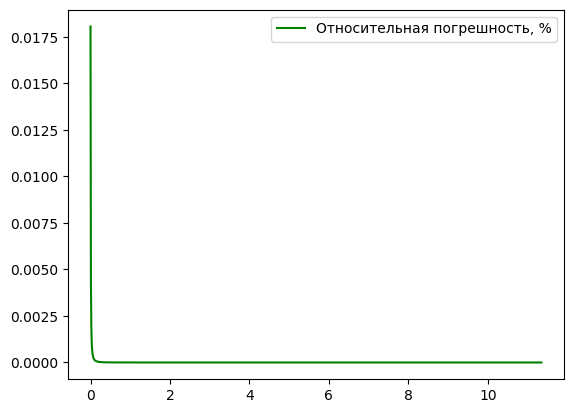

In [268]:
# Функция для аппроксимации методом наименьших квадратов
def gaussian_elimination(matrix: np.ndarray, vector: np.array) -> np.ndarray:
    n = len(vector)
    
    # Прямой ход метода Гаусса
    for i in range(n-1):
        pivot = matrix[i, i]    
        for k in range(i+1, n):
            factor = matrix[k, i] / pivot
            matrix[k, i:] -= factor * matrix[i, i:]
            vector[k] -= factor * vector[i]

    # Обратный ход метода Гаусса
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (vector[i] - np.dot(matrix[i, i+1:], x[i+1:])) / matrix[i, i]

    return x

def approx(x: np.ndarray, y: np.array, degree: int) -> np.ndarray:
    n: int = len(x)
    X: np.ndarray = np.ones((n, degree + 1))
    for i in range(1, degree + 1):
        X[:, i] = x ** i
    coefficients: np.ndarray = gaussian_elimination(np.dot(X.T, X), np.dot(X.T, y))
    return coefficients

# Аппроксимация решения и получение коэффициентов полинома
degree = 2
c,b,a = approx(solution_x, solution_y[:, 0], degree)
print("Коэффициенты квадратичного полинома методом наименьших квадратов: ")
print(f"a = {a}")
print(f"b = {b}")
print(f"c = {c}")
def f_approx(t):
    return a * t**2 + b*t + c

# Вычисление среднеквадратичного отклонения 
t_approx = list(solution_x)
y_approx = [f_approx(t) for t in t_approx]
abs_errs = [abs(y_approx[i] - solution_y[:, 0][i]) for i in range(len(solution_y[:,0]))]
rel_errs = [abs(abs_errs[i] / solution_y[:,0][i]) for i in range(len(abs_errs))]
std_err = sum([e**2 for e in abs_errs]) / len(abs_errs)
print(f'Среднеквадратичное отклонение: {std_err}')

print(rel_errs)
plt.plot(t_approx, rel_errs, color="green", label="Относительная погрешность, %" )
plt.legend()
plt.show()

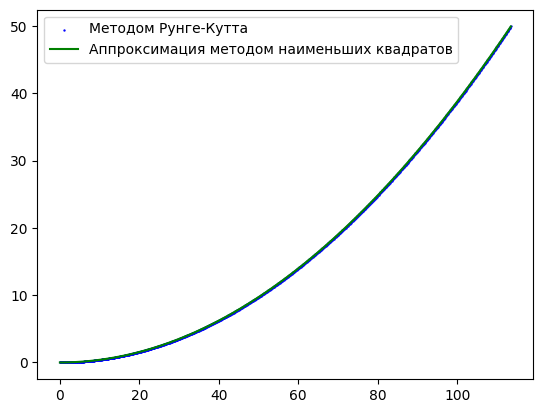

NameError: name 'real_roots' is not defined

In [269]:

# Построение графика аппроксимации функции
t_plot = np.linspace(0, np.max(solution_x ), 100)
y_plot = [f_approx(t) for t in t_plot]
plt.scatter(solution_x * v, solution_y[:, 0], color="blue", marker="o", s=0.5, label="Методом Рунге-Кутта")
plt.plot(t_plot * v, y_plot, color="green", label="Аппроксимация методом наименьших квадратов" )
plt.legend()
plt.show()

# Определение времени всплытия и точки всплытия
def get_time(a: float, b: float, c: float, H: float) -> float:
    roots = np.roots([a, b, c - H])
    return roots[roots > 0]

T = get_time(a, b, c, H)
L = v * T

# Вывод значений
print("Время всплытия (T):", T)
print("Абсцисса точки всплытия (L):", L)